In [1]:
import gym
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
obs_space = env.observation_space.n
act_space = env.action_space.n
print("observation_spaces {}; action_space {}".format(obs_space, act_space))

observation_spaces 500; action_space 6


## 创建一个随机策略

也就是对于任何一个状态，任何一个动作，其被选中的概率都是$\frac{1}{\text{act_space}}$

In [3]:
import numpy as np
policy = np.full((obs_space, act_space), 1.0 / act_space)

之后验证一下所产生的策略的数据类型，数据值是否符合要求等等。

In [4]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / act_space)
assert np.allclose(np.sum(policy, axis=1), 1.0)

## 与游戏交互

In [5]:
def generate_session(policy, max_steps = 10 ** 4):
    states = []
    actions = []
    total_reward = 0.0
    
    state = env.reset()
    for step in range(max_steps):
        action = np.random.choice(np.arange(act_space), p=policy[state])
        next_state, reward, done, info = env.step(action)
        
        # 记录state, action和rewards
        states.append(state)
        actions.append(action)
        total_reward += reward
        
        if done:
            break
        state = next_state
    return states, actions, total_reward

In [6]:
states, actions, total_reward = generate_session(policy)

之后再判断一下生成数据的类型

In [7]:
assert type(states) == type(actions) == list
assert len(states) == len(actions)
assert type(total_reward) in (float, np.float)

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_18126/1414657024.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert type(total_reward) in (float, np.float)


查看一下随机策略下的奖励分布:

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

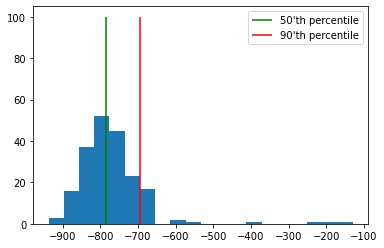

In [9]:
sample_rewards = [generate_session(policy, 1000)[-1] for _ in range(200)]
plt.hist(sample_rewards, bins=20)
plt.vlines(np.percentile(sample_rewards, 50), 0, 100, label="50'th percentile", color="green")
plt.vlines(np.percentile(sample_rewards, 90), 0, 100, label="90'th percentile", color="red")
plt.legend()

## 筛选elites

In [10]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    选择奖励rewards大于等于percentile的状态和动作对。
    
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    
    indexs = [index for index, rewards in enumerate(rewards_batch) if rewards >= reward_threshold]
    
    
    elite_states = [states_batch[index] for index in indexs]
    elite_actions = [actions_batch[index] for index in indexs]
    
    elite_states_flat = [state for elite_state in elite_states for state in elite_state]
    elite_actions_flat = [action for elite_action in elite_actions for action in elite_action]
    
    return elite_states_flat, elite_actions_flat

之后测试一下代码

In [11]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


## 更新策略

In [12]:
def update_policy(elite_states, elite_actions):
    """
    依据elite state和elite actions更新策略
    """
    new_policy = np.zeros((obs_space, act_space))
    
    occurences = {}  # 记录状态被访问的次数
    for idx in range(obs_space):
        occurences[idx] = 0  # 初始化状态访问次数为全零。
    
    for idx, state in enumerate(elite_states):
        new_policy[state, elite_actions[idx]] += 1
        occurences[state] += 1
    
    # 归一化策略
    for idx in range(obs_space):
        if occurences[idx] == 0:  # 如果这个状态没有被采样到，那么就全部归一化为均匀概率
            new_policy[idx, :] = 1.0 / act_space
        else:
            new_policy[idx, :] /= occurences[idx]
            
    return new_policy

测试代码

In [13]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


## 训练

In [14]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

mean reward = -22.420, threshold=7.000


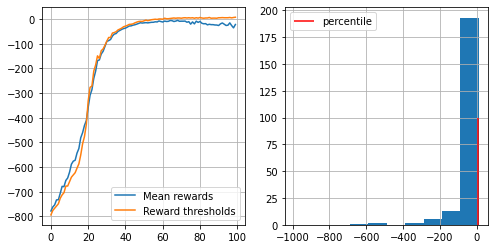

In [15]:
n_sessions = 250
percentile = 50
learning_rate = 0.2

policy = np.ones((obs_space, act_space)) / act_space
log = []
for i in range(100):
    sessions = [generate_session(policy) for i in range(n_sessions)]
    batch_states, batch_actions, batch_rewards = zip(*sessions)
    
    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    
    # display results on chart
    show_progress(batch_rewards, log, percentile)

## 封装

交叉熵方法其实是先采样，然后拿到较好的样本，之后再依据较好的样本来更新策略的。

```python
class CrossEntropyMethod(object):
    def __init__(self, env, percentile):
        """传入环境实例和百分比参数"""
        pass
    
    def generate_episodes(self, num_episodes):
        """生成episodes, 返回多个episodes轨迹"""
        pass
    
    def select_elites(self, episodes_state, episode_action, episode_reward):
        """筛选elites, 返回state和action对"""
        pass
    
    def update_policy(self, learning_rate):
        """更新策略"""
        pass
```

In [34]:
import numpy as np

class CrossEntropyMethod(object):
    def __init__(self, env, percentile, learning_rate):
        """传入环境实例和百分比参数"""
        self.env = env
        self.obs_space = env.observation_space.n
        self.act_space = env.action_space.n
        self.percentile = percentile
        self.policy = np.ones((self.obs_space, self.act_space)) / self.act_space
        self.lr = learning_rate
    
    def generate_episodes(self, max_steps, num_episodes):
        """生成episodes, 返回多个episodes轨迹"""
        episodes_state = []
        episodes_action = []
        episodes_reward = []
        for i in range(num_episodes):
            states = []
            actions = []
            episode_reward = 0.0
            state = self.env.reset()
            for j in range(max_steps):
                action = np.random.choice(np.arange(self.act_space), p=self.policy[state])
                next_state, reward, done, info = self.env.step(action)
                
                states.append(state)
                actions.append(action)
                episode_reward += reward
                
                if done:
                    break
                state = next_state
                
            episodes_state.append(states)
            episodes_action.append(actions)
            episodes_reward.append(episode_reward)
            
        return episodes_state, episodes_action, episodes_reward
        
    
    def select_elites(self, episodes_state, episodes_action, episodes_reward):
        """筛选elites, 返回state和action对"""
        thread_reward = np.percentile(episodes_reward, self.percentile)
        indexs = [index for index, reward in enumerate(episodes_reward) if reward >= thread_reward]
        
        elites_state = [episodes_state[idx] for idx in indexs]
        elites_action = [episodes_action[idx] for idx in indexs]
        
        elite_state = [state for elite_state in elites_state for state in elite_state]
        elite_action = [action for elite_action in elites_action for action in elite_action]
        assert len(elite_state) == len(elite_action), "len elite_state not eq elite_action"
        
        return elite_state, elite_action
    
    def update_policy(self, elite_state, elite_action):
        """更新策略"""
        new_policy = new_policy = np.zeros((obs_space, act_space))
        
        occurences = {}
        for idx in range(self.obs_space):
            occurences[idx] = 0  # 初始化状态访问次数为0。
        
        for idx, state in enumerate(elite_state):
            new_policy[state, elite_action[idx]] += 1  # 记录状态动作对采取的次数。
            occurences[state] += 1
        
        for idx in range(self.obs_space):
            if occurences[idx] == 0:
                new_policy[idx, :] = 1.0 / self.act_space
            else:
                new_policy[idx, :] /= occurences[idx]
        
        self.policy  = self.lr * new_policy + (1 - self.lr) * self.policy

In [40]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = CrossEntropyMethod(env=env, percentile=0, learning_rate=0.2).select_elites(states_batch,actions_batch,rewards_batch)
test_result_40 = CrossEntropyMethod(env=env, percentile=30, learning_rate=0.2).select_elites(states_batch,actions_batch,rewards_batch)
test_result_90 = CrossEntropyMethod(env=env, percentile=90, learning_rate=0.2).select_elites(states_batch,actions_batch,rewards_batch)
test_result_100 = CrossEntropyMethod(env=env, percentile=100, learning_rate=0.2).select_elites(states_batch,actions_batch,rewards_batch)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


mean reward = -23.760, threshold=6.000


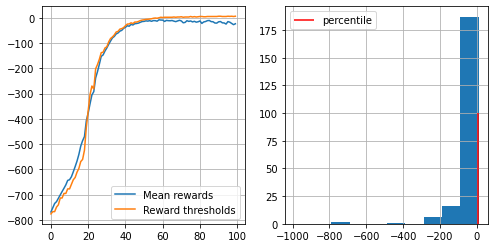

In [43]:
import gym

env = gym.make("Taxi-v3")

cem = CrossEntropyMethod(env=env, percentile=50, learning_rate=0.2)
log = []
for i in range(100):
    episodes_state, episodes_action, episodes_reward = cem.generate_episodes(max_steps=10**4, num_episodes=250)
    elite_state, elite_action = cem.select_elites(episodes_state, episodes_action, episodes_reward)
    cem.update_policy(elite_state, elite_action)
    #print(i, np.mean(episodes_reward))
    show_progress(episodes_reward, log, 50)